In [1]:
import torch
from diffusers import (AutoencoderKL, EulerAncestralDiscreteScheduler,
                       StableDiffusionXLAdapterPipeline, T2IAdapter)
import webdataset as wds
import random
import h5py
import models

In [2]:
subj=1
data_path = "/fsx/proj-fmri/shared/mindeyev2_dataset"
batch_size = 12
data_type = torch.float16

In [3]:
if subj==1:
    num_train = 24958
    num_test = 2770
test_batch_size = num_test

def my_split_by_node(urls): return urls
    
train_url = f"{data_path}/wds/subj0{subj}/train/" + "{0..36}.tar"
print(train_url)

train_data = wds.WebDataset(train_url,resampled=False,nodesplitter=my_split_by_node)\
                    .shuffle(750, initial=1500, rng=random.Random(42))\
                    .decode("torch")\
                    .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                    .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
train_dl = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False, drop_last=True, pin_memory=True)

test_url = f"{data_path}/wds/subj0{subj}/test/" + "0.tar"
print(test_url)

test_data = wds.WebDataset(test_url,resampled=False,nodesplitter=my_split_by_node)\
                    .shuffle(750, initial=1500, rng=random.Random(42))\
                    .decode("torch")\
                    .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                    .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
test_dl = torch.utils.data.DataLoader(test_data, batch_size=test_batch_size, shuffle=False, drop_last=True, pin_memory=True)

/fsx/proj-fmri/shared/mindeyev2_dataset/wds/subj01/train/{0..36}.tar
/fsx/proj-fmri/shared/mindeyev2_dataset/wds/subj01/test/0.tar


In [4]:
# load betas
f = h5py.File(f'{data_path}/betas_all_subj0{subj}.hdf5', 'r')
# f = h5py.File(f'{data_path}/betas_subj0{subj}_thresholded_wholebrain.hdf5', 'r')

voxels = f['betas'][:]
print(f"subj0{subj} betas loaded into memory")
voxels = torch.Tensor(voxels).to("cpu").to(data_type)
print("voxels", voxels.shape)
num_voxels = voxels.shape[-1]

# load orig images
f = h5py.File(f'{data_path}/coco_images_224_float16.hdf5', 'r')
images = f['images'][:]
images = torch.Tensor(images).to("cpu").to(data_type)
print("images", images.shape)

subj01 betas loaded into memory
voxels torch.Size([27750, 15724])
images torch.Size([73000, 3, 224, 224])


In [5]:
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float32).cuda()
vae.requires_grad_(False)
vae.eval()

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, ep

In [6]:
ret_cap = ['Children wearing costumes picking at food on a table.', 'A group of people standing around a kitchen preparing food.', 'A person in a wetsuit surfing on a turquoise wave.', 'a windsurfer some water a hill sand and some kayaks', 'A view of a building in a country different than the US.', 'A pasta dish with broccoli and another side.', 'a white plate and a piece of white cake ', 'two women are trying to catch a frisbee', 'A cat laying on the roof of a vehicle parked near a building.', 'A man surfs a wave in the water. ', 'A big commercial plane flying in cloudy skies.', 'A boy on a surfboard in the ocean ', 'A bear that is standing in the water.', 'A man in pajamas laying in bed with a laptop.', 'Attendants are walking near a huge parked airplane.', 'A living room that has a couch in it.', 'A man with short hair and a black button down coat holds a cell phone and looks up.', 'A herd of cattle grazing on a grassy hill.', 'A giraffe standing on top of a lush green field.', 'A toilet sitting in a bathroom on top of a tiled floor.', 'A little girl holding a brown teddy bear.', 'A view of a bunch of people skiing and posing for a picture.', 'a clock on the top of a small tower on the top of a building', 'A man and women standing in a field, both are holding umbrellas. ', 'A giraffe standing on top of a lush green field.', 'A collection of trinkets and little girls purses.', 'black and white vases sitting next to each other on a counter ', 'Attendants are walking near a huge parked airplane.', 'A group of kites flying through a blue sky.', 'a girl wearing a white bonnet holding a black luggage bag', 'A white plate topped with a cut in half sandwich with eggs.', 'A woman sitting on top of a green couch near a window.', 'A refrigerator filled with soft drinks next to a shelf.', 'a bath room with its door open and light on', 'A buffet of hot dog sandwiches, burritos, beans, and peas.', "a city's traffic with buses, cars and pedestrians crossing.", 'a busy road that is next to some buildings', 'Different kinds of food rest on a plate.  ', 'A man swinging a bat on a baseball field.', 'A couple of white boats on the water.', 'A couple of people standing in a field flying a kite.', 'Three different giraffes standing in a open area of a zoo.', 'A train engine carrying carts down a track.', 'A seemingly endless line of blue beach chairs with blue umbrellas on the beach.', 'A white vase filled with flowers with green leaves.', 'Some people in a very big field flying some kites.', 'The city bus has stopped in traffic outside.', 'A long bus pulling into a bus stop near buildings.', 'A couple of people standing in a field playing with a frisbee.', 'A polar bear standing near a tree on grass', 'A woman walking a bike in front of her small dog.', 'An ocean with gulls flying and a boat', 'A formation of red fighter jets flying through a blue sky.', 'A lot if birds are standing at the beach shore', 'Moped parked on the side of a road next to a sidewalk.', 'A train is stopped in front of the station which is nearly empty of boarders.', 'Two sandwiches sitting on top of papers on a table.', 'A batter, catcher and umpire during a baseball game.', 'A man riding a bike past a parked car.', 'Two dressed teddy bears sitting together by a window.', 'A boy in a green jersey with a bag on a baseball field', 'a large hot dog that  is on some paper', 'A man on skis in the snow with poles. ', 'A table is set with snack foods outdoors.', 'a person riding a skate board at a skate park', 'Two women sitting on a metal bench next to a fence.', 'A group of elephants bathing and playing in the water.', 'There are two parking meters together at a beach', 'A man riding skis down the side of a ski slope.', "A close-up of a giraffe's face with tree limbs in the background. ", 'A meal consists of shrimp, broccoli, and a lemon wedge on a white plate.', 'a water supply with some kites flying over it ', 'Single boat near the shore of an ocean.', 'A person in a field flying a parasail and having fun.', 'A man with glasses using a cell phone.', 'The storefront of a small open produce market.', 'A little baby eating food on a table with a bear on it.', 'A teddy bear with brown fur and light brown feet.', 'a train on a track near a platform ', 'a large giraffe that is standing up tall', 'A sailboat in the middle of the water by a cruise ship.', 'Three horses graze next to a scenic lake.', 'a surfer is seen mid air jumping from a wave', 'A tennis player in action on the court.', 'A colorful cat on a counter beside a microwave oven.', 'A beautiful woman holding a tennis ball and racquet.', 'A man wearing a backpack while riding a skateboard.', 'A herd of cattle walking through a lush green field.', 'Skiers go down the mountain in the sun', 'Someone uses a long pole to take a pizza out of a brink oven.', 'A clock tower in an open space with decorative plaques under the clock.', 'A bowl of food sitting on a table next to a plastic container with kiwi.', 'A person on a surfboard catching a wave in the ocean.', 'Two stuffed bears are sitting side by side. ', 'Two black and white puppies staring out a window.', 'A white kitchen with green labels and hanging pots', 'a couple of people sit on a chair on some grass ', 'A street sign view in a very blurry picture.', 'A trash man standing behind a truck next to a pile of garbage.', 'A dour young man sits on a horse.', 'A man playing tennis on the tennis court. ', 'A bathroom with white painted walls and white fixtures, including a toilet with the seat raised up.', 'A bird standing on top of a beach next to water.', 'A seemingly endless line of blue beach chairs with blue umbrellas on the beach.', 'A man riding skis over a snow covered ski slope.', 'A train going down the train tracks in a building. ', 'A man is getting ready to throw a frisbee.', 'A kitchen with a large stove top oven.', 'a person riding a surf board on a wave', 'A pizza with lots of different topping son it.', 'A FedEx plane wheels along on a tarmac. ', 'A group of young people playing with frisbee on field.', 'A baseball player swings at a ball during a game.', 'A woman kneels near a bench as a man with his foot on a skateboard sits on the bench.', 'Small dish of meat with cucumber on top of rice.', 'The Ansett-ANA airplane is parked on the lawn.', 'A group of people behind a white picket fence watching a person in the grass with a dog and small group of sheep.', 'The view of a room with several different utensils displayed on shelves.', 'A bathroom with a sink and mirror is shown through the door way. ', 'A woman standing on a tennis court holding a racquet.', 'a close up flowers and plants inside of a bowl \n', 'A living room with a sofa, chair, and a picture on the wall.', 'A toilet with a couple of floor mats near them.', 'A young boy holding an umbrella wearing big sneakers', 'A kitchen area with all white cabinets mad a white refrigerator.', 'A giraffe walks amongst the trees in a park. ', 'A surfer rides an ocean wave, a swimmer looking on.', 'A couple of men sitting across from each other at a table.', 'A person is riding a snowboard down a hill in the snow.', 'Three zebras walking in a row through dirt.', 'A woman standing in front of an apple.', 'A couple riding on the back of an elephant on a dirt road.', 'A silver and red bus in parking lot next to cars.', 'Woman holding the reins of a horse in front of a crowd.', 'A table with a piece of construction paper, scissors and sewing thread.', 'A plate with vegetables, seafood and rice on a table.', 'A motorcycle parked next to a street sign.', 'a twin bed with a white comforter on it and a little table next to it', 'Three people sitting at an outside table near a hillside.', 'A sink, toilet and mirror inside of a bathroom.', 'Two men riding motorcycles on a race track', 'A lot of food that is on top of a table.', 'A giraffe is walking on the green field of grass.', 'A peacock-shaped kite flying overhead in a blue sky.', 'A giraffe is near some green leafy branches', 'A jet airplane is flying in the sky.', 'Food has been plated on two separate small trays.', 'A red fire hydrant in the grass. with a building and cones in the background.', 'A woman riding skis down a snow covered slope.', 'A zebra standing next to a lot of trees.', 'A baseball player holding a baseball bat on a field.', 'A man sitting at a desk in front of a computer.', 'an image of man holding two cellphone to his ears', 'A dog sits in the shade near a yellow Frisbee.', 'a man is standing around some buckets of food', 'A young girl laying in the bed with her arm out', 'There is a woman bending down with a racket playing tennis.', 'A woman riding on the back of a brown horse.', 'A white toilet sitting next to a white sink.', 'A passenger bus near a bus stop, people next to it.', "The large six wheel truck has two tires strapped on it's bed.", 'A group of motorcycles parked next to each other.', 'A white truck parked on the beach with its door open ', 'A large clock towers in a downtown metropolitan area.', 'A couple of people that are playing a frisbee game.', 'A herd of sheep standing next to a building.', "a clocks that's  on a wall that is falling down", 'A man rest on a rock while taking a break from surfing.', 'A large jetliner flying over a lush green forest.', 'a blue and yellow plane is in the sky', 'a close up of a plate of food with sandwiches', 'Young man in dark suit wearing red tie smiling for camera.', 'A large bunch of green bananas sitting in a banana tree.', 'Two women on a grassy field playing with a frisbee.', 'A white and black bird standing in the surf ', 'A train that is sitting on the tracks.', 'A used roll of toilet paper next to a toilet.', 'A guy on skis squatting while going down a hill.', 'A baby girl holding a brown teddy bear.', 'Large group of multi colored kites being flown over a crowd.', 'Several motor bikes going down a city road.', 'These four zebra are walking in a field.', 'A Woman feeding food with her hands to a Giraffe.', 'a young boy playing with an elephant while a baby elephant watches', 'there is a cow lying in the street with people talking by.', 'A person is on a bench near a grassy field.', 'Fresh fruits and vegetables sit for sale at a store.', 'A bus going down a country road ', 'A black bear is climbing a log and want to have fun. ', 'There are women wearing glove handling different breads.', 'a living room with a long couch in it ', 'A busy city street lined with stores, parked cars and people.', 'A herd of zebra standing on a lush green field.', 'A train is shown stopped at a train station.', 'A group of people that are flying some kites.', 'A group of people with ski gear walk over snowy weather.', 'A young man jumping up into the air to catch a Frisbee.', 'A man standing on a snow covered slope riding skis.', 'A red truck sitting on top of a beach.', 'two black trays of different types of food and some bread', 'A city scene is shown with stop lights is shown.', 'A clock sitting in the middle of a road next to a small house.', 'A red stop sign sitting on the side of a road with the word " Driving \' written under it.', 'A group of people who are sitting around a table.', 'Close up of a stop sign with a "4-way" sign under it.', 'The large plane is in front of a building.', 'A large long train on a steel track.', 'a toilet with some hand rails above it', 'White chairs sit around a polished wood dining table while a sectional sofa sits in the background.', 'Three large airplanes parked on the runway ', 'A red motorcycle parked on the side of a road surrounded by trees.', 'A single person riding a wave on a surfboard', 'Three men and a woman sit at a high table with wine glasses on it.', 'Food in a pain is shown up close. ', 'A young woman using a Wii controller playing a game and laughing.', 'A airplane that is flying in the sky.', 'a zebra walking in a grassy field on a clear day', 'A man taking a large bite from a sausage sandwich.', 'A giraffe is walking through the grass .', 'A boat sitting on a shore tied to a rope.', 'A fighter jet flying through a blue sky with smoke behind it.', 'A man riding on the back of a green motorcycle.', 'Two giraffes walking next to each other in front of some cliff rocks.', 'a plate with different kind of food on it.', 'A long silver train traveling through a wooded area.', 'this school bus is yellow and black with dark windows ', 'A half bathroom with tile flooring and a toilet and vanity.', 'People sitting on motorcycles on the side of a road.', 'A plane prepares to land on an airport runway. ', 'A person singing into a microphone while holding a cell phone.', 'Four people on horses walk down a trail.', 'A ZEBRA IS STANDING IN THE FOREST LOOKING ', "Someone's suitcase left outside against the wall opened up", 'Two parachutes flying over the water held by two people. ', 'This doggy looks so peaceful sitting on the soft-seat rocking chair.', 'Two people with surfboards are walking along the beach with a dog.', 'A boat sitting on top of a body of water near buildings.', 'The surfer is attempting to ride a chaotic wave.', 'A man winding up to throw a frisbee in the park', 'Man on cherry picker fixing the wire lines.', 'A large red double decker bus parked in a parking lot.', 'There are 3 separate dishes comprised of apple slices, sushi and tomatoes, and broccoli and noodles. ', 'A man about to hit a tennis ball on a concrete court.', 'A man standing on a tennis court with a tennis racquet.', 'A couple long horned cows laying on top of hay.', 'a close up ofa clock on top of a shelf ', 'A man riding a snowboard down the side of a snow covered slope.', "A couple of guys flying a kite at water's edge.", 'A man smiling while wearing a jacket and a tie.', 'A great shot of a full kitchen and partially a table. ', 'A black bear walking across a lush green field.', 'a couple of people sitting on a bench in a park.', 'a person that is on a horse in a field', 'A man standing on a tennis court holding a tennis ball.', 'A small elephant standing  in dirt behind a wire fence.', 'There are many flavors of donuts on the paper.', 'A skier in a red jacket and yellow helmet going down a hill.', 'A large white jetliner sitting on top of an airport.', 'A man surfs over the crest of a wave in the ocean.', 'a couple of men are laying on surfboards in the water', 'A man riding a motorcycle with a woman on back of it.', 'A man riding a skateboard next to orange cones.', 'A lone giraffe standing by a tree in the wild.', 'Four bowls containing fruits and vegetables arranged decoratively', 'A woman on skis is at the bottom of a ski slope, with her hands in the air. ', 'A zebra standing next to a baby zebra in a field.', 'A stop sign and a lamp post on a street corner', 'A pizza sitting on top of a table covered in cheese', 'A mattress is not very far off the ground.', 'A microwave oven sitting on top of a blue table.', 'A woman is sitting in a baseball stand with  baseball glove on her hand.', 'Two men in historical clothing stand in a covered wagon attached to two donkeys while one man shoots a pistol and holds a rifle up.', 'A cat standing inside of a suitcase that is empty.', 'A man in full gear and helmet snowboarding on a hill.', 'An elephant stands immobile in its zoo habitat.', 'a man standing next to a car with a snow board', 'A marina filled with boats that have been tied to the ledge.', 'A tall tower with a clock on it', 'the zebra is looking on away from the other zebra', 'A man riding a skateboard around white cones.', 'A motorcycle is parked next to a building.', 'A man sits with a teddy bear on his shoulders. ', 'Locomotive passenger train moving through green landscape ', 'A neatly made bed with unique curtains in a bedroom.  ', 'A woman tennis player is in position to play.', 'The head of a giraffe is extended over a fence.', 'a person sitting a a table with a plate ', 'A man petting his dog on a boat. ', 'A woman is sitting in a garden tub while brushing her teeth for a window view.', 'A tennis player holding a tennis ball and racquet on a tennis court.', 'A man taking a swing at a tennis ball', 'An image of an vase set with flowers in it.\n', 'A home with lots of wood darkly stained.', 'People are standing in a shopping district with stores.', 'A dog is laying on a blanket with a stuffed toy.', 'A giraffe walking past some tall trees on some grass', 'A man with a racket stands on a court.', 'A white refrigerator freezer in a kitchen next to a stove top oven.', 'A photo of a train coming to a train platform.', "A man standing next to an elephant who stole his hat with it's trunk.", 'A woman with nice breast holding a book while sitting next to a dog.', 'A train caboose is sitting beside train tracks.', 'A spotted cat is laying on a bare mattress.', 'This is an excellent example of a clean and orderly industrial kitchen.', 'A white plate topped with a salad filled with vegetables.', 'A dog laying on a quilt in front of a window.', 'Large adult elephant standing in the bushes eating. ', 'A woman pours canned tomatoes into a blender. ', 'A herd of elephants walking along a dry grass field.', 'A woman with a brown purse climbs from a Purple Route bus.', 'An old man standing while holding a video game remote as people watch. ', 'Two gray elephants fighting each other bumping heads.', 'A person on a surfboard in the water.', 'A table topped with a bunch of bananas and other fruit.', ' Young giraffe walking in a clearing between many trees ', 'A brown dog eating food from a dog bowl.', 'A bathroom showing the toilet all done in white.', 'A giraffe standing on a lush green hillside.', 'A kitten eating food out of a dish on the kitchen floor.', 'A group of people gather near a table with food.', 'A batter, catcher, and umpire can be seen at home plate.', 'A large bunch of bananas hanging from a tree.', 'a person riding a surf board on a wave', 'There is a person in the water with a small board.', 'An overview of a city dump near a river.', 'A man riding a motorcycle with two  children on board.', 'Man and woman exchanging words on stage with horse ', 'A giraffe on the plains with a mountain in the background.', 'A boat is going down a green colored river.', 'a zebra waking through the herd across grass', 'A bunch of young adults or teenagers posing for a picture on a sandy beach', 'Two zebras walking side by side in an enclosure', 'a kitchen with a sink a coffee maker and a microwave', 'A red headed skateboarder sips on his drink.', 'A group of people standing around a kitchen counter.', 'A computer that is sitting on top of a desk.', 'A group of people on skis that is standing in the snow.', 'a cross country skier moves around the corner of a trail', 'A bed in a room with two windows. ', 'A man riding on a surfboard on a wave.', 'a very tall giraffe standing in the wilderness', 'A group of motorcyclists driving down the road. ', 'A man kite board in the ocean on clear blue water.', 'A tree filled with green bananas with lots of leaves.', 'A single zebra grazing in a grass field.', 'A living room filled with furniture and a flat screen TV.', 'A train going down the train tracks in a building. ', 'A white airplane is under an overhead hangar.', 'Fresh fruits and vegetables sit for sale at a store.', 'A professional baseball player looks down at the ball in his hand', 'a couple of giraffes eating out of a basket', 'a male in a white shirt and a piece of pizza', 'a close up of a cows near other cows ', 'A city street that has a group of people walking down it.', 'A group of young men sitting on concrete ledge eating pizza.', 'Side view of both a near cow and a far cow on a grassy hill.', 'Fork under part of cake on the plate pulling off a slice', 'A room with white walls and bright lights.', 'A woman holding a Nintendo Wii controller up in the air.', 'Two cows are head butting each other in the pasture.', 'A woman wearing a heat, leaning against a wall and talking on a cell phone.', 'There is a white Vigrin Atlantic Plane on a runway', 'two zebras are walking in a field next to some plants', 'Fork under part of cake on the plate pulling off a slice', 'two black trays of different types of food and some bread', 'Two elephants at the zoo looking through a fence.', 'a vase of flowers and decorative bowl sit on a table', 'A woman standing next to a man with a frisbee.', 'A man wearing skis standing on top of a slope.', "'A man riding on the back of a black horse.", 'A blue cloth covered table topped with trays of food.', 'An elephant walking in the dry grass outside.', 'A man in a black wetsuit riding a wave.', 'A double-decker bus is on a street outside a building.', 'an image  of a guy on the bus that is parked on the street', 'An aerial shot of a show boarder overhead.', 'A young man jumping up into the air to catch a Frisbee.', 'Three zebras stand beside a container overflowing with grass.', 'A man with shorts and a headband on in motion. ', 'Four jets flying parallel in the sky with smoking trailing behind.', 'A door open to a bathroom with the vanity showing.', 'A baseball player swinging a bat while standing next to home plate.', 'A man riding a wave on top of a surfboard.', 'A bathroom showing tub, sink, and toilet ', 'The base ball player is ready at the plate.', 'A big and smaller sheep outside looking towards the camera.', 'a person riding a horse on a beach ', 'A couple of horses graze while a dog looks on', 'A group of cars is waiting at a traffic stop.', 'A woman sitting in bed with a small dog.', 'Two bagel halves topped with cream cheese and salmon.', 'A stop sign is hanging over the street on a holder.', 'A dog lays on a bench in a park.', 'A red and black old style steam train inside of a large train station.', 'A large green airplane sits on the runway.', 'A bathroom with a glass door and a sink.', 'A large black dog laying on a green grass covered field.', 'A person on a field throwing a ball.', 'A large clock of big ben in london uk', 'A bunch of ripe bananas sitting on a cutting board next to Grape-nuts and yogurt.', 'A row of jet airliners parked next to a runway.', 'Close up of a teddy bear lying face down', 'A herd of zebra walking across a dry grass field.', "A couple of bags of someone's belongings that were left unattended. ", 'A giraffe is near some green leafy branches', 'A herd of cattle grazing on a lush green field.', 'Two brown and white cows in a grassy field', 'People browsing a large market display of fresh produce.', 'A cat laying next to a stainless steel bowl.', 'A man and woman standing next to each other.', 'Three people on a park bench look at the phone of the person in the middle.', 'A pan with a pastry covered in meat and veggies.', 'A person flying a kite high up in the sky.', 'a kitchen that has a icebox in it', 'A TV entertainment center in the corner of the room.', 'a bathroom with a fancy toilet in the corner ', 'A crispy pizza with vegetables, cheese and sauce.', 'A young boy riding a skateboard down a sidewalk.', 'a woman in a white dress is standing in the street', 'A surfer on a yellow surf board wiping out', 'A person riding skis down a snow covered slope.', 'A white toilet sitting in a bathroom next to a sink.', 'A room with a toilet next to a shower fixture.', 'A computer desk topped with lots of computers.', 'A couple of elephant trainers working with some elephants.', 'there is a small zebra walking along the beach', 'A person is doing a high jump on some skis.', 'A diverse group of people seated around small white tables.', 'This room is well lit by large windows.', 'Two large cows and one small cow standing in a field', 'two phones are sitting next to each other on the floor', 'A zebra eating grass in front of some small bushes.', 'A variety of vegetables on display at a produce stand.', 'A baseball player holding a bat on top of a baseball field.', 'A group of people walking around a park under a kite filled sky.', 'A kitchen area filled with antique kitchen items', 'The group of many different people are sitting together. ', 'A zebra standing on dirty area with trees in the background.', 'A man and a woman riding a horse drawn carriage.', 'A bathroom with a tub, toilet and sink.', 'a parked train sits next to some people walking in a depot', 'A chair next to a desk with a lamp, a monitor, a notebook and paper items.', 'A white bus driving down a street next to the side of a road.', 'A living room filled with furniture and a large wooden cabinet.', 'A baby girl holding a brown teddy bear.', 'A surfer wears a completely black wetsuit including a head covering.', 'A crowd of people standing around a ski slope.', 'A man working on a propeller driven airplane.', 'a number of cows in a field near trees', 'A person wearing skis standing in the snow.', 'This bathroom could benefit from a decorating makeover.', 'A zebra standing in tall brown grass near some trees.', 'The children are learning how to properly ski.', 'A couple of men riding waves on surfboards.', 'A person feeding a kitten a bottle of milk.', 'Man in racing suit and helmet on skateboard on roadway.', 'people riding bikes among cars and buses ', 'Group of street lights hanging on the same street sign. ', 'A man wearing a tuxedo standing behind a microphone.', 'A man sitting on top of a surfboard next to the ocean.', "Giraffe holding it's head mid way with a wooden gate behind it.", 'A herd of sheep standing on top of a grass covered hillside.', 'A group of sheep are in a grassy field near a house.', 'A sink and mirror in a very small bathroom.', 'A man riding a surfboard along a wave.', 'A herd of zebra standing on top of a lush green field.', 'A dog playing with a sheet in its mouth as the camera flashes light on its eyes.', 'four people on a beach with surf boards', 'Elephant walking on dirt path near forested area.', 'A manb standing in front of a black horse near other horses.', 'A woman standing in front of a mirror wearing a tie.', 'a tower with a clock is on top if a building', 'A longboarder squats to take a tight curve.', 'a street sign sitting between two benches sitting by a sidewalk', 'A very cute cat laying in the corner.', 'A giraffe is trotting across a green grassy field. ', 'A person that is about to ski in the snow.', 'assorted animals like giraffes and zebras standing by a river', 'A row of parked motorcycles sitting in a parking lot.', 'A white park bench sitting in the middle of a forest.', 'A multi layer wedding cake with white frosting.', 'Large signs are suspended from the buildings above the city street. ', 'A table has an orange table cloth on it', 'a fork thrust into what looks like a pan filled with potato chips', 'A large water tower next to a train on the tracks.', 'a couple of men that are in a baseball field', 'Snow boarder in snow suit riding on board.', 'A row of houses with large chimneys and pointy roofs..', 'Several horses are huddled closely in front of a mountain range.', 'A person kite board in the ocean under a gray sky.', 'The big brown  cows are in a field.', 'a cat playing with a stuffed toy on the carpet', 'A mother elephant and her baby are standing together outside.', 'a group of elephants near a body of water ', 'Many people are skiing through the snowy mountain.', 'There are two red double decker buses in a road.', 'A black animal walking around a green forest.', 'Two giraffes standing next to each other in a grassy area.', 'A zebra in a well-kept area walking during the day.', 'A full fridge door sits open in an empty kitchen', 'A man in shirt with napkin tucked in at his neck.', 'a desk with a laptop and monitor and keyboard', 'The man is on his surfboard trying to surf the waves in the water. ', 'A train is stopped in front of the station which is nearly empty of boarders.', 'A long green and yellow train traveling down tracks.', 'A bunch of green buses parked in front of a building.', 'An empty kitchen with wood-paneled cabinets and black appliances.', 'an assortment of tropical fruits with some large yellow flowers', 'A very pretty plate holding broccoli and two other items.', 'An airplane painted like a giraffe next to another small airplane.', 'Small bird sitting on a skateboard posed in front of dark blue background cloth.', 'some hot dogs in separate plastic containers on counters', 'A group of zebra on a grassy field.', 'Two young boys sitting with stuffed animals and a paper sign.', 'several male cows coming up a hill to cross the street', 'A lone boy is skateboarding down a street.', 'THERE ARE A LOT OF ELEPHANTS WALKING ON THE FIELD', 'Black and white photograph of a surfer balancing on her board', 'A man flying a kite on a very clear day.', 'A crowd of people skiing across a snow covered hill.', 'Two men sitting on top of a white toilet.', 'A man hugs a woman as they sit in the snow with snowboards on.', 'A lone horse grazes on grass near trees.', 'A couple of cows laying on top of green grass covered field.', 'Two giraffes standing by a tree with a forest in the background.', 'A lone rider drives a ten speed bike down the street.', 'A single elephant alone in a natural habitat.', 'Two plastic containers have a soup and a salad in them.', 'a couple of large airplanes that are parked in a parking lot', 'A kitchen with white cupboards, stainless steel stove and dishwasher, grey walls and a tan tiled floor and black and tan marbled countertop.', 'A man riding a board on top of a wave.', 'A gold clock featuring a man and a bird.', 'A red bird is in a tree full of leaves.', 'There is young man holding a baby closely.', 'A statue above a clock on the face of a building.', 'A herd of sheep that are grazing in a field.', 'A passenger train that is traveling on the tracks.', 'Various electronics, a bed, a dresser, and a trashcan in a make shift bedroom.', 'A monochrome room with a fireplace and living area', 'A smart phone hooked up to a charger sitting on a table.', 'A large Thai jetliner parked on an airport tarmac.', 'A woman sitting at a table cutting a princess cake.', 'Two brown horses grazing on a field of green grass.', 'A helicopter flying next to two people parachuting.', 'A large brown bear sitting in his habitat.', 'Dock area with urban area on cloudy day.', 'A passenger jet airliner with the word "AIRFRANCE" is in the air in front of a cloudy sky.', 'there is a small kitten that has fallen asleep on the bed', 'A man wearing black tennis clothes serving a tennis ball in a tennis game.', 'A couple of people standing in a field flying a kite.', 'A young child sitting on a black couch holding a Nintendo Wii controller.', 'A food with many different dishes of food on it', 'Kids in a restaurant are chowing down on pizza. ', 'A large gray elephant walking through a lush green field,', 'A bunch of ripe bananas hanging from a metal hook.', 'Several train tracks with a train on one of them.', 'A close up of several zebras grazing in a field.', 'A field full of giraffe standing on top of dry grass.', 'Two zebras walking around a large cluster of rocks.', 'A bathroom with a large mirror under vanity lights.', 'A stop sign and a freeway sign are covered with stickers.', 'A couple of kids hovering over a pizza sitting on top of a wooden cutting board.', 'A desktop computer sitting on top of a counter.', 'The view of a room with several different utensils displayed on shelves.', 'A giraffe walking through a tree filled forest.', 'A woman hitting a tennis ball with a racquet.', 'The cow is perched on a rather steep hill.', 'A zebra standing on top of a dry grass field.', 'The man is hitting the ball during the baseball game.', 'The woman has 2 frisbees to exercise her two dogs on a country road.', 'A close view of a piece of broccoli next to a salad.', 'A virgin airlines plane in a blue sky.', 'A giraffe standing on top of a lush green field.', 'The small girl is holding a partially peeled banana.', 'A man and woman riding on a motorcycle as others look on.', 'A large light brown horse standing next to a baby horse.', 'A group of zebra on a grassy field.', 'A brown and white cow standing on a grass field.', 'Woman sitting on a horse walking on gravel.', 'An elephant in a field surrounded by trees.', 'A man and child flying kites in a  field', 'A gray cat lying on a floor in a room', 'There are several motorcycles at the side of the road.', 'A small group of people are flying kites on the grass.', 'A baseball player at home plate swings at a pitch.', 'a gray and white teddy bear with a flower on its head', 'A small herd of elephants are standing around each other.', 'A young boy with red hair sitting below a young man.', 'A big pile of assorted fresh produce close together.', 'A pizza on a table with cheese and olives. ', 'Yellow taxi parked on the side of the road with a meter in front of it. ', 'A field of sheep on a dirt lot around farmers.', 'Cars are travelling along a highway with caution posts on the side.', 'A person that is using a pair of skis.', 'A small private air plane on a run way strip.', 'A green, orange and white train in a train station.', 'A young man stands by two red motorcycles.', "A close up view of a giraffe's face.", 'A man surfing waves on his surf board in the ocean. ', 'A woman holding an umbrella around a bunch of people.', 'A blue bus driving down a curvy street.', 'A passenger jet coming in for a landing over a big city.', 'A couple of men herding sheep down a road.', 'A man holding an MP3 player in his hand while wearing headphones.', 'An adorable small dog wearing sunglasses while sitting in a back seat.', 'A bride and groom teddy bear each in a coffee cup on a saucer.', 'Large bear on the side of a stream in a rocky area.', 'A small bathroom with brightly painted blue walls', 'Black and white photograph of a person windsurfing.', 'Kids playing soccer, all wearing differnet colors, and part of a goalpost.', 'Sidewalk next to a freeway on a cloudy day with a red bus.', 'A man riding a bicycle using a phone on a city street', 'A car is driving toward several skyscrapers on a one way street.', 'A large crowd stands around a line of various parked motorcycles.', 'A group of sheep in grassy field next to bushes.', 'White cows eating grass under trees and the sky', 'a couple of people on surf boards ride in the water', 'A woman in a blue shirt holding onto two horses next to little girls.', 'a close up ofa clock on top of a shelf ', 'two men are balancing on the back of a horse', 'A grey cat laying on a mat on a sofa.', 'a giraffe is standing in a dirt field', 'A brown and white dog standing next to a white horse.', 'A cake in the shape of a video game controller.', 'A little boy is on a state board on the cement.', 'a living room filled with furniture and a flat screen TV.', 'A person surfing a wave in the ocean.', 'Two zebras standing next to each other against a grey background. ', 'I am unable to see an image above.', 'Boats are docked in the water near a city. ', 'A group of horses trailing behind one another', 'The giraffes are walking together in the desert. ', 'A medium sized all white bathroom with a big black trash can.', 'An abandoned train car sitting next to a parked truck.', 'two pizzas on the stove, one with mushrooms and the other with basil', 'A man and woman walk their two dogs in San Francisco.', 'A rider on a surf board with the board coming off the wave.', 'a living room with  a table and chairs and a rotating fan', 'A peron riding a surfboard on top of water.', 'A man wearing glasses eating a pastry covered in glaze.', 'A group of people on wet suits sitting on surfboards in the ocean.', 'a brown bear is standing in the grass', 'A man stands in front of a horse drawn carriage.', 'Multiple street signs on the corner of Park Ave and E 34th St', 'A pizza is sitting on a plate in a kitchen.', 'A grocery store filled with lots of fresh produce.', 'The small bathroom has many towels in it. ', 'The city bus has stopped in traffic outside.', 'The old clock has a small sign above it.', 'A living room filled with furniture and a table.', 'A young boy who is eating a carrot.', 'A large jetliner sitting on top of an airport tarmac.', 'A group of zebras are standing in a clearing with a young zebra beside the mother.', 'A man riding a snowboard down a snow covered slope.', 'a plane in a plant and cars parked besides it', 'a dog sitting on a bench with a sky background', 'A store filled with a wooden shelf with glass figurines.', 'The guy is so excited playing his video game.', 'A lap top sitting on the corner of a desk un-attended.', 'A large transport train traveling through rural country side.', 'A horse drawn carriage goes down this street surrounded with tall buildings.', 'A couple of brown bears walking across a forest.', 'A small bathroom with a shower and toilet.', 'A yellow parrot is perched on a tree limb.', 'People walking around the park with a few horses', 'A photo of a person playing the Nintendo Wii.', 'A zebra is standing in the grass facing forward.', 'A woman taking a picture with her cell phone.', 'A man wearing glasses and a shirt and tie poses for a photo outside, in a courtyard', 'Three brown cows grazing in field with trees in background.', 'A kid standing in the snow on skis.', 'A kid is getting ready to hit a baseball.', 'A woman holding a tennis racket on a court. ', 'The lonely lighthouse serves as protection for ocean goers.', 'A baseball player standing on top of a lush green field.', 'A woman laying on top of the surfboard next to a cat. ', 'A giraffe is eating by a fence. ', 'A man in brown jacket doing a trick on a snowboard.', 'A desk area covered with pop cans and food', 'A skier rides on a red rail on a snow filled slop.  ', 'A train riding through a railroad track. ', 'two zebras walk along the grass by a bird', 'A book sitting on top of a bed in the dark.', "A cat laying on a rug playing with a dog's tale.", 'A bathroom being worked on with a sink with no faucet handles and a toilet that has no cover on it.', 'A vegetable and fruits stand in front of a big building. ', 'Train platform with people on it waiting for their train under a clock', 'A red and black suitcase and a black duffel bag on some grass.', 'Two blonde girls standing next to each other.', 'A group of people on horseback enjoying their trail ride.', 'A cat lies in the window sill of the bedroom.', 'The lunch plate includes both meat and vegetable choices.', 'Two giraffe standing next to each other on a dirt road.', 'A group of giraffe standing next to each other on a dry grass field.', 'Two horses stand in a sloped field of grass', 'a person riding skis on a snowy surface', 'A little boy sitting on top of a brown couch next to a remote control.', 'A zebra walking across a dirt field near a tree. ', 'a man is skiing down a hill covered mountain', 'A snowboarder is gliding backwards down a slope.', 'A red motorcycle on a carpet inside of a house.', 'A man riding a skateboard up the side of a ramp.', 'A horse eating hay in a open yard.', 'Pizza with mushrooms spinach, tomato and cheese on a blue plate.', 'A man and woman cutting the umbilical cord of a baby.', 'The plate is full of banana and orange slices.', 'The picture of a cat under a car.', 'a large clock with roman numerals is hung from a building', 'so many people and vehicles on the street and road signs also', 'A snowboarder is in the middle of a jump through the air. ', 'This living room has a cream colored sofa and two arm chairs.', 'A group of people riding horses along the beach.', 'A fruit stand selling flowers and tropical fruit.', 'Pile of oranges at a market with leaves, branches, and snow.', 'A red train pulling into a crowded train station.', 'A white toilet sitting inside of a bathroom.', 'A person sitting against a wall as another walks by with an umbrella.', 'Black and white photograph of a man sitting on a toilet.', 'a person on skis making her way up a snowy mountain ', 'a little flying her kite on the beach', 'A woman standing on a tennis court holding a racquet.', 'A woman with a black horse on a road near some building', 'A commuter train driving down the rail road tracks.', 'A model train on a model bridge decorated with christmas lights.', 'A business-attired man leans against a marble counter-top to chat in front of a smiling black-haired woman.', 'An empty bathroom with a large mirror and sink.', 'A gazelle standing near a zebra in the dirt', 'A street lined with motorcycles and loan biker riding along', 'A doorway into a bathroom with a sink and vanity.', 'Woman showing facial expression while holding cell phone.', 'A cat sniffs the end of a banana', 'Two red and white traffic signs atop a pole.', 'A couple of giraffe standing next to each other.', 'A bus traveling down a city street next to street signs.', 'A shirtless surfboarder riding a large wave in the ocean', 'A man riding skis down the side of a mountain.', 'A table of food that includes peanuts and two hot dogs.', 'a girl that is up to the plate with a bat', 'Two planes sitting on runway with engines running.', 'A baseball player sliding into home base during a game.', "A large jetliner with a painting on the side of it's cabin.", 'an older man is brushing his teeth at home', 'a room with a small desk and bed, there is a cat laying on the bed.', 'A man in a baseball uniform about to throw a ball.', 'A man riding a motorcycle down the middle of a street.', 'Attendants are walking near a huge parked airplane.', 'A line of horses following one another in the field', 'Six women are standing next to a table with all kinds of desserts spread on it.', 'The base ball pitcher is pitching the ball.', 'A tray filled with plates and dishes full of food.', 'the woman is holding a cat with a hat on ', 'A downtown area of a city with buildings and billboards. ', 'four different buses people and a red black and white truck', 'a small wooden bathroom with the toilet seat up ', 'a giraffe stands in a large grassy field ', 'A bear walking through a lush green forest.', 'A man and woman holding white gaming controllers.', 'The passenger bus is stopping alongside of the street.', 'a group of giraffe standing next to each other in an open field', 'A man on a surfboard riding an ocean wave.', 'A smiling man hand feeds a giraffe as two other giraffes stand in the background.', 'A baseball player at home plate swings at a pitch.', 'A brown bear standing on a  moss covered rock hillside.', 'A white plate topped with different types of food.', 'there is a old bike down bus next to another bus', 'A bowl of food with meat in a sauce, broccoli and cucumbers. ', 'A man and woman are playing a video game', 'A person holding up a flip phone in their hand.', 'The bathroom sink displays an Elvis Presley likeness.', 'A flower is on an object that is lit. ', 'MAN ON SKATEBOARD LOOKING AHEAD TO HIS NEXT MOVE', 'A man riding an orange motorcycle down a road next to a bush covered landscape.', 'A windsurfer riding on top of a wave.', 'A plant is in a pot sitting on a table.', 'A woman helps two girls prepare a sandwich with tomato, lettuce and avocado.', 'A room with marble floors and the door open.', 'a clock on the top of a small tower on the top of a building', 'A older baseball player is in motion with a ball in the air.', 'A church with a clock tower and a bell. ', 'A man riding a surfboard on a wave in the ocean.', 'A baseball player hitting a ball with a bat.', 'A white refrigerator and counter in a room.', 'a man leaning forward as he swings a tennis racket', 'A modern bathroom design with a skylight above the toilet.', 'A table topped with four plates filled with food.', 'Red stuffed animals wtih graduation caps and gold bow ties. ', 'a cow standing by the fence as it looks towards the camera', 'A guy and girl take a photo with a giraffe in the background.', 'A small group of zebras that are eating grass. ', 'A box of Ulundu Vade is shown in a refrigerator.', 'A sign sitting on the side of a road.', 'a couple of men talk in a park area ', 'A full view of some electronics on the table. ', 'A red double decker bus driving down the street.', 'A row of parked motorcycles sitting in a parking lot.', 'two zebras on a dirt road with trees in the background', 'Adult elephant standing next to wire fence outdoors.', 'A black train engine on a track in a town.', 'A woman in a blue shirt holding onto two horses next to little girls.', 'An elephant standing in a lush leaf filled jungle.', 'A group of men standing next to each other holding up cellphones.', 'A man wearing a uniform holding a baseball bat.', 'A man riding a wave on top of a surfboard.', 'Two cats play with each other near some computers.', 'A bunch of people are brushing their teeth together.', 'A group of zebras that are standing in the dirt.', 'A group of friends standing next to each other.', 'A zebra standing next to a tree on a grass covered field.', 'A harbor filled with lots of boats surrounded by tall buildings.', 'a big bed sits in a room along with a couch ', 'A view of a living room with a laptop sitting on a table.', 'A train yard with one train and a bunch of empty train cars.', 'A person on a court with a tennis racket.', 'A plate with some meat and vegetables on it', 'A man is snow skiing next to tree tops.', 'A giraffe walking across a street in front of a truck.', 'a close up ofa clock on top of a shelf ', 'A man on a motorcycle drives down the street', 'A very large elephant in a big grassy field.', 'A white bed sitting under a picture mounted on a wall.', 'A white cat sitting in the drivers seat of a car.', 'A pretty young lady using a laptop computer with a black cat on top of it.', 'A dog touches noses with a horse through a fence.', 'An animal standing on top of a lush green field.', 'A young boy riding a train while hanging his head out of the window.', 'The living area is open and brightly lit by the tall window.', 'A man in a black wetsuit on a red surfboard.', 'A man in a wet suit is surfing a wave.', 'A young child is trhowing a white Frisbee.', 'A counter is laden with many types of foods. ', 'A man with shorts and a headband on in motion. ', 'A cat sitting on top of a laptop computer.', 'A guy on a cellphone making a goofy face and wearing a sombrero.', 'A group of horses are getting their feet wet.', 'A sliced pizza with vegetables and feta cheese.', 'A flower arrangement is sitting in a black vase.', 'DOUGHNUTS KEPT IN A PLATE ON A TABLE.', 'A large steel boat floating on top of water.', 'View of kitchen shows microwave across from refrigerator.', 'A boardwalk with benches and a French fry stand.', 'A group of people walking along a beach.', 'A pizza sitting on top of a pizza pan with toppings.', 'Cat outline in darkness with white stripe background', 'Two bikini clad women ride horses on the beach.', 'In the foreground of the picture there are couples riding on motorcycles on a city street', 'A man riding a wave on a surfboard in the ocean.', 'A desktop computer sitting on top of a wooden desk.', 'A black and white photograph on sidewalk next to wall.', 'there is a surfer that is riding a wave in the ocean', 'A pizza with purple cabbage topping on a table next to white bowl.', 'A large church tower with a clocked embedded in it.', 'A black desk with a desktop computer monitor and keyboard sitting on top of it.', 'A man riding a board on the water while flying a kite.', 'A man riding down the side of a snow covered ski slope.', 'A tall wooden grandfather clock sitting up against a wall.', 'an elephant is standing near some a body of water', 'Buses line both sides of an urban street.', 'A man and a woman walking walking two large dogs on a leash.', 'Red robin sitting on wooden bench near trees.', 'A baby next to a fence petting a sheep.', 'a girl playing tennis hits the ball back to the opponet', 'a man on his cell phone walking down the sidewalk', 'Several people riding surfboards in the ocean waves.', 'there are two black and white cows that are sitting on the ground', 'A black and white dog walking down a  sidewalk.', 'A woman is riding on a horse in order to win the race.', 'A refrigerator freezer next to a stove top oven.', 'A young boy holding a kite next to a body of water.', 'a brown couch a coffee table a lamp window and television set', 'A giraffe standing in a lush green field.', 'a vintage photo of a bathroom with a toilet an tub', 'A white plate topped with a pickle and other vegetables.', 'A woman sitting in front of a table with a paper.', 'A woman riding a bike down the middle of a street.', 'The man is walking in the train yard to inspect the engines.', 'A couple of people riding on the backs of horses.', 'there is a small tablet and a keyboard and computer on a desk', 'A black and white photo of a crane standing in the water across from a city.', 'A vase with flowers sitting on a table outside.', 'A red fire hydrant sitting next to a green plant.', 'A giraffe standing next to a pile of rocks.', 'A giraffe standing taller than the trees that surround it', 'A small airplane flying in the air near land. ', 'A large passenger jet taking off from a runway.', 'A kitchen sink next to a window and an automatic dishwasher.', 'A surfboarder riding a wave in the ocean', 'The table has four chairs and food on the top.', 'A man riding an ocean wave on a surfboard.', 'a close up of broccoli inside of corn bread', 'A bird flying over some waves seeking food.', 'a sign in a cityscape light sup in the rain', 'A zebra standing in a field filled with green grass.', 'A group of zebras are standing in a clearing with a young zebra beside the mother.', "A woman sitting on a horse while he's walking. ", 'Yellow military jet making pass against gray cloudy sky.', 'Black bear in a large field of grass. ', 'Trays that have a bunch of different doughnuts.', 'A group of people gather near a table with food.', 'A man that is standing on a tennis court with a racquet.', 'there is a dog in the grass playing with a frisbee', 'A kitchen filled with lots of clutter and a table with blue metal chairs.', 'A cat laying under the exhaust pipe of a car.', 'A printer sitting next to a desk with a laptop, computer monitor and mouse on it.', 'A woman on a grassy field holding a frisbee.', 'Cows grazing in a field on a farm', 'A propeller plane that is on the runway.', 'two people riding horses on a city street ', 'A long kitchen with a cluttered counter ', 'a green pole with a clock on the top of it ', 'A few birds sitting on a rock next to a lake.', 'A living area with a bed, television and laptop on a desk.', 'A tray of food sitting on top of a white table.', 'A man in a fez standing with a bucket on an intersection.', 'A tennis player holding a tennis ball and racquet on a tennis court.', 'A white bus on the street on a cloudy day. ', 'Three people are standing on a beach with surfboards.', 'A little boy on the beach trying to fly a kite.', 'an image of a man on a skateboard doing tricks', 'A red train chugs down the tracks by some farmland.', 'A dog is sitting in a grassy clearing, in a forested area, with a twig in his mouth. ', 'Several plates shaped like a slice of pizza are shown.', 'A full refrigerator and freezer are standing open.', 'Three large dogs are lying down on a bed. ', 'A crowd of people standing along a fence near an airport.', 'zebra bends down to take a bite of grass on ground', 'a man and a little boy playing with a kite', 'a plate with a cooked dish and a spoon sitting on a table', 'THIS IS A PICTURE OF TWO CITY BUSES SIDE BY SIDE ON THE STREET', 'A snowboarder is on the edge of a painted slope.', 'A man cooks food outdoors near his two dogs.', 'A man surfing waves in the ocean on his surf board. ', 'Two zebras stand side-by-side grazing in a green pasture.', 'A baseball player pitching a ball on a field.\n', 'A microwave oven sitting on top of a blue table.', 'Looking at a barge cross a channel of water under a cloudy sky', 'a formal dining room and living room with the table set', 'A close up of several pikes locked on a gate.', 'A little girl riding on the back of a brown and white horse.', 'A man outdoors jumping to catch a frisbee.', 'The large herd of cows are all around the large field.', 'A couple of zebra seen behind the fence of their pin area at the zoo', 'A man flying through the air while riding skis.', 'A bald man plays an informal tennis game.', 'Add you own paint or woodstain to these unfinished cabinets.', 'A couple on a motorcycle stop to take a picture.', 'A man riding a skateboard down an ally.', 'Man riding a snow board down a long slick area.', 'A man sitting with a cake in front of him.', 'A guy on skis jumps high over the snowy hill. ', 'Three colleagues standing together for a group photo of themselves. ', 'People standing on a sidewalk in front of a crosswalk.', 'A small giraffe standing in a dirt field.', 'A man with a grey shirt and black jacket takes a picture of his bathroom while standing in the mirror.', 'a close up of a person riding a motorcycle ', 'A young boy holding a baseball bat playing a game of baseball.', 'A man takes a picture with a cell phone.', 'A wooden desk with an open laptop computer sitting on top of it.', 'A lot of zebras standing in the sand on a hot summer day.', 'A blue and white bus is traveling down the road. ', 'A peep hole view in to a nice looking room.', 'A Thai Airways passenger plane goes in for landing over a beach.', 'A mounted police officer riding down a city street past parked cars.', 'A group of sheep standing next to a wall in a building.', 'Three pieces of broccoli sitting next to a cranberry desert.', 'A jet airplane is flying in the sky.', 'A black and white picture with a woman leading cows down a road', 'The large room has a kitchen and a living space in it.', 'A pair of yellow and green motorcycles parked next to each other.', 'A woman in a blue shirt holding onto two horses next to little girls.', 'A blue bus driving down a street next to cars.', 'A herd of elephants is standing in tall grass', 'A man that is on a box with a skateboard.', 'THERE IS A BOAT THAT IS ON THE BEACH', 'A large group of people on scooters on the road.', 'Sea gulls rest and preen in a parking lot.', 'A woman is brushing her teeth with a white and yellow toothbrush.', 'A zebra standing on top of a grass field.', 'a person on skis on a snowy surface ', 'A red train traveling down rail road tracks.', 'A giraffe stands tall and looks out among some brush.', 'A surfboard leaning on a wall near some stairs and a door.', 'A clean living room is seen in this picture.']
test_image, test_voxel = None, None
vox_lat = models.Voxel2StableDiffusionModel(use_cont=True).cuda()
ckpt = torch.load("/fsx/proj-fmri/mihirneal/MindEyeV2/train_logs/models/autoencoder/last.pth")
vox_lat.load_state_dict(ckpt['model_state_dict'])
vox_lat.eval()
# vox_lat = vox_lat.to(data_type)

Voxel2StableDiffusionModel(
  (lin0): Sequential(
    (0): Linear(in_features=15724, out_features=4096, bias=False)
    (1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
    (2): SiLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
  )
  (mlp): ModuleList(
    (0-3): 4 x Sequential(
      (0): Linear(in_features=4096, out_features=4096, bias=False)
      (1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
      (2): SiLU(inplace=True)
      (3): Dropout(p=0.25, inplace=False)
    )
  )
  (lin1): Linear(in_features=4096, out_features=16384, bias=False)
  (norm): GroupNorm(1, 64, eps=1e-05, affine=True)
  (upsampler): Decoder(
    (conv_in): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (up_blocks): ModuleList(
      (0): UpDecoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 256, eps=1e-06, affine=True)
            (conv1): LoRACompatibleConv(256, 256, kernel_size=(3, 3), str

In [7]:
for test_i, (behav, past_behav, future_behav, old_behav) in enumerate(test_dl):  
                # all test samples should be loaded per batch such that test_i should never exceed 0
        assert len(behav) == num_test
                
                ## Average same-image repeats ##
        if test_image is None:
            voxel = voxels[behav[:,0,5].cpu().long()]
            image = behav[:,0,0].cpu().long()
                    
            unique_image, sort_indices = torch.unique(image, return_inverse=True)
            for im in unique_image:
                locs = torch.where(im == image)[0]
                if test_image is None:
                    test_image = images[im][None]
                    test_voxel = torch.mean(voxel[locs],axis=0)[None]
                else:
                    test_image = torch.vstack((test_image, images[im][None]))
                    test_voxel = torch.vstack((test_voxel, torch.mean(voxel[locs],axis=0)[None]))

In [8]:
test_image.shape

torch.Size([982, 3, 224, 224])

In [9]:
test_voxel = test_voxel.to(torch.float32).cuda()
test_voxel.shape

torch.Size([982, 15724])

In [10]:
vox_lat = vox_lat.to(torch.float32)

In [20]:
vae_list = []
with torch.inference_mode():
    with torch.cuda.amp.autocast(enabled=False):
        for i in range(15):
            out = vox_lat(test_voxel[[i]] * 0.18215)
            reconst = vae.decode(out.detach()/0.18215).sample
            vae_list.append(reconst)
            # vae_out = torch.vstack((vae_out, out))
        vae_out = torch.vstack(vae_list)

In [21]:
# vae_out = vae_out.cuda()
vae_out.shape

torch.Size([15, 3, 512, 512])

In [22]:
from torchvision import transforms
def denormalize(tensor, mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]):

    denormalized = tensor.clone()
    for channel in range(tensor.size(0)):
        denormalized[channel] = tensor[channel] * std[channel] + mean[channel]
    return denormalized
    
def convert_tensor_to_PIL_image(tensor):
    # Denormalize the tensor
    denormalized_tensor = denormalize(tensor)
    
    # Convert the tensor to a PIL Image
    pil_image = transforms.ToPILImage()(denormalized_tensor)
    
    return pil_image

In [23]:
from torchvision.transforms import ToPILImage
from IPython.display import display

Ground Truth output: 



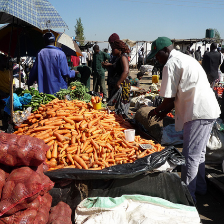

Ground Truth output: 



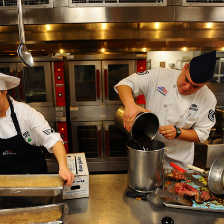

Ground Truth output: 



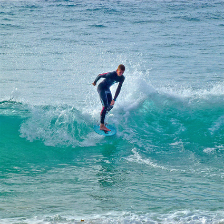

Ground Truth output: 



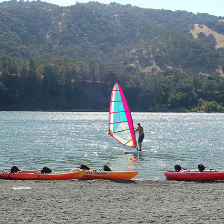

Ground Truth output: 



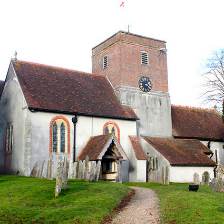

Ground Truth output: 



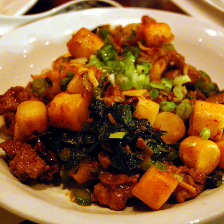

Ground Truth output: 



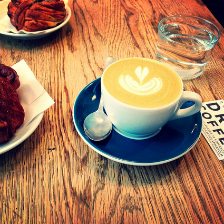

Ground Truth output: 



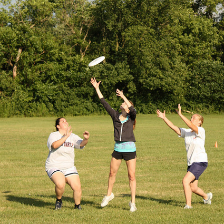

Ground Truth output: 



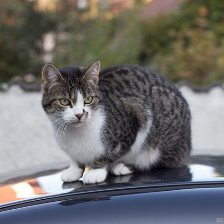

Ground Truth output: 



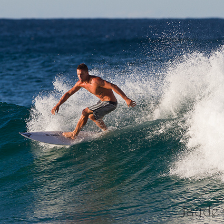

Ground Truth output: 



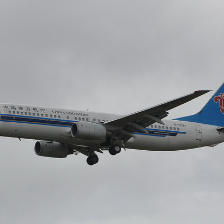

Ground Truth output: 



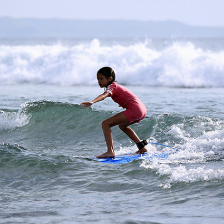

Ground Truth output: 



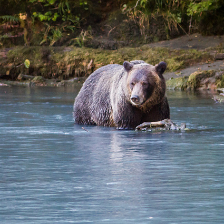

Ground Truth output: 



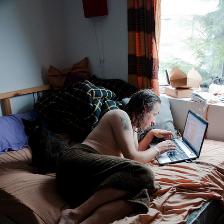

Ground Truth output: 



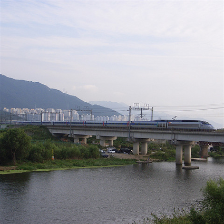

In [29]:
to_pil = ToPILImage()
for i in range(15):
    img = convert_tensor_to_PIL_image(vae_out[i].squeeze(0))
    gt_img = to_pil(test_image[i])

    # print("VAE output: \n")
    # display(img)

    print("Ground Truth output: \n")
    display(gt_img)

In [25]:
vae_t2i = T2IAdapter.from_pretrained("/fsx/proj-fmri/mihirneal/MEV2_exp/src/t2i_blur/saved_ckpt/saved_ckpt", torch_dtype=torch.float16, adapter_type="full_adapter_xl")
model_id = "stabilityai/stable-diffusion-xl-base-1.0"
scheduler = EulerAncestralDiscreteScheduler.from_pretrained(
    model_id, subfolder="scheduler")
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)

pipe = StableDiffusionXLAdapterPipeline.from_pretrained(
    model_id, vae=vae, adapter=vae_t2i, safety_checker=None, torch_dtype=torch.float16, scheduler=scheduler
)

pipe.to("cuda")

Keyword arguments {'safety_checker': None} are not expected by StableDiffusionXLAdapterPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionXLAdapterPipeline {
  "_class_name": "StableDiffusionXLAdapterPipeline",
  "_diffusers_version": "0.22.0.dev0",
  "_name_or_path": "stabilityai/stable-diffusion-xl-base-1.0",
  "adapter": [
    "diffusers",
    "T2IAdapter"
  ],
  "force_zeros_for_empty_prompt": true,
  "scheduler": [
    "diffusers",
    "EulerAncestralDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [39]:
# pipe = pipe.to(data_type)
ret_cap[2]

'A person in a wetsuit surfing on a turquoise wave.'

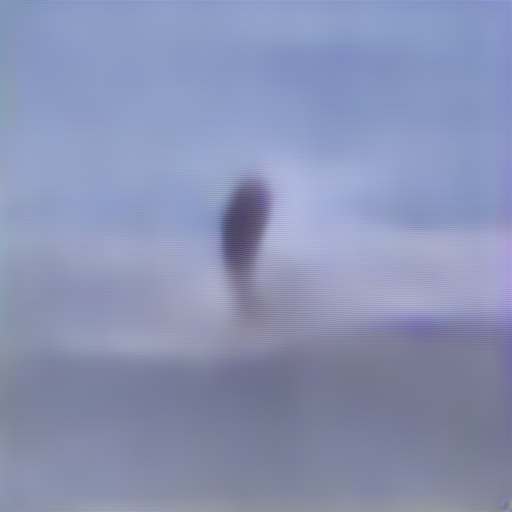

In [40]:
img = convert_tensor_to_PIL_image(vae_out[2].squeeze(0).to(data_type))
img.show()

In [27]:
import numpy as np
from diffusers.utils import PIL_INTERPOLATION
def transform_PIL(image):
    image = [image]
    image = [np.array(i.resize((1024, 1024), resample=PIL_INTERPOLATION["lanczos"])) for i in image]
    image = [
            i[None, ..., None] if i.ndim == 2 else i[None, ...] for i in image
        ]  # expand [h, w] or [h, w, c] to [b, h, w, c]
    image = np.concatenate(image, axis=0)
    image = np.array(image).astype(np.float32) / 255.0
    image = image.transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return image

img_ten = transform_PIL(img)

In [31]:
for i in range(15):
    prompt = ret_cap[i]
    img = convert_tensor_to_PIL_image(vae_out[i].squeeze(0).to(data_type))
    img_ten = transform_PIL(img)
    negative_prompt = "anime, cartoon, graphic, text, painting, crayon, graphite, abstract, glitch, deformed, mutated, ugly, disfigured"
    gen_images = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        image = img_ten,
        num_inference_steps=50,
        adapter_conditioning_scale=0.6,
        adapter_conditioning_factor=1.0,
        guidance_scale=7.5,
    ).images[0]
    gen_images.save(f"imgs/test{i}.jpg")

tensor([[[[0.1451, 0.1451, 0.1412,  ..., 0.6078, 0.6118, 0.6118],
          [0.1451, 0.1451, 0.1451,  ..., 0.6078, 0.6118, 0.6118],
          [0.1412, 0.1451, 0.1490,  ..., 0.6078, 0.6078, 0.6078],
          ...,
          [0.1882, 0.1961, 0.2078,  ..., 0.3059, 0.2980, 0.2941],
          [0.2000, 0.2039, 0.2118,  ..., 0.2627, 0.2549, 0.2471],
          [0.2078, 0.2118, 0.2118,  ..., 0.2431, 0.2353, 0.2275]],

         [[0.1647, 0.1569, 0.1490,  ..., 0.6314, 0.6431, 0.6431],
          [0.1608, 0.1569, 0.1490,  ..., 0.6275, 0.6353, 0.6353],
          [0.1569, 0.1529, 0.1490,  ..., 0.6235, 0.6275, 0.6275],
          ...,
          [0.1804, 0.1882, 0.1961,  ..., 0.2706, 0.2627, 0.2627],
          [0.2000, 0.2039, 0.2039,  ..., 0.2353, 0.2314, 0.2314],
          [0.2118, 0.2118, 0.2118,  ..., 0.2157, 0.2196, 0.2196]],

         [[0.1451, 0.1451, 0.1451,  ..., 0.6627, 0.6745, 0.6863],
          [0.1451, 0.1451, 0.1451,  ..., 0.6627, 0.6706, 0.6784],
          [0.1490, 0.1490, 0.1529,  ..., 0

  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[[[0.2784, 0.2784, 0.2784,  ..., 0.4510, 0.4667, 0.4745],
          [0.2784, 0.2784, 0.2745,  ..., 0.3961, 0.4078, 0.4157],
          [0.2706, 0.2706, 0.2706,  ..., 0.3059, 0.3137, 0.3176],
          ...,
          [0.2980, 0.2980, 0.3020,  ..., 0.2667, 0.2510, 0.2392],
          [0.3059, 0.3059, 0.3098,  ..., 0.2235, 0.2039, 0.1961],
          [0.3137, 0.3137, 0.3176,  ..., 0.1922, 0.1765, 0.1686]],

         [[0.2196, 0.2196, 0.2157,  ..., 0.4353, 0.4510, 0.4588],
          [0.2196, 0.2196, 0.2157,  ..., 0.3765, 0.3843, 0.3922],
          [0.2196, 0.2196, 0.2118,  ..., 0.2706, 0.2784, 0.2824],
          ...,
          [0.2824, 0.2824, 0.2824,  ..., 0.2549, 0.2431, 0.2353],
          [0.2941, 0.2941, 0.2941,  ..., 0.2039, 0.1961, 0.1961],
          [0.3020, 0.3020, 0.3020,  ..., 0.1686, 0.1686, 0.1686]],

         [[0.2000, 0.2000, 0.2039,  ..., 0.4431, 0.4588, 0.4667],
          [0.2000, 0.2000, 0.2039,  ..., 0.3882, 0.4039, 0.4118],
          [0.2078, 0.2078, 0.2039,  ..., 0

  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[[[0.5098, 0.5020, 0.4902,  ..., 0.5333, 0.5490, 0.5569],
          [0.4980, 0.4941, 0.4902,  ..., 0.5333, 0.5490, 0.5529],
          [0.4824, 0.4863, 0.4980,  ..., 0.5373, 0.5451, 0.5451],
          ...,
          [0.5255, 0.5333, 0.5373,  ..., 0.5059, 0.5059, 0.5020],
          [0.5333, 0.5373, 0.5373,  ..., 0.5020, 0.4941, 0.4863],
          [0.5412, 0.5373, 0.5373,  ..., 0.5020, 0.4863, 0.4784]],

         [[0.6392, 0.6314, 0.6078,  ..., 0.6078, 0.6235, 0.6314],
          [0.6275, 0.6196, 0.6039,  ..., 0.6039, 0.6157, 0.6235],
          [0.6039, 0.6039, 0.5961,  ..., 0.5961, 0.6039, 0.6039],
          ...,
          [0.5804, 0.5804, 0.5765,  ..., 0.5294, 0.5176, 0.5098],
          [0.5843, 0.5843, 0.5804,  ..., 0.5255, 0.5137, 0.5059],
          [0.5882, 0.5843, 0.5804,  ..., 0.5255, 0.5137, 0.5059]],

         [[0.8196, 0.8000, 0.7647,  ..., 0.8314, 0.8510, 0.8627],
          [0.8000, 0.7843, 0.7569,  ..., 0.8235, 0.8431, 0.8549],
          [0.7608, 0.7569, 0.7451,  ..., 0

  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[[[0.4078, 0.4078, 0.4000,  ..., 0.4941, 0.4980, 0.5020],
          [0.4000, 0.4000, 0.4000,  ..., 0.5176, 0.5255, 0.5294],
          [0.3843, 0.3922, 0.4039,  ..., 0.5490, 0.5608, 0.5686],
          ...,
          [0.4549, 0.4667, 0.4784,  ..., 0.5294, 0.5255, 0.5255],
          [0.4549, 0.4667, 0.4745,  ..., 0.5216, 0.5216, 0.5137],
          [0.4588, 0.4667, 0.4745,  ..., 0.5216, 0.5176, 0.5059]],

         [[0.4196, 0.4157, 0.4078,  ..., 0.5137, 0.5216, 0.5216],
          [0.4157, 0.4157, 0.4078,  ..., 0.5333, 0.5412, 0.5490],
          [0.4078, 0.4118, 0.4118,  ..., 0.5569, 0.5725, 0.5804],
          ...,
          [0.5059, 0.5059, 0.5137,  ..., 0.5333, 0.5255, 0.5176],
          [0.5098, 0.5098, 0.5137,  ..., 0.5333, 0.5255, 0.5216],
          [0.5098, 0.5098, 0.5137,  ..., 0.5333, 0.5255, 0.5255]],

         [[0.4745, 0.4627, 0.4431,  ..., 0.5490, 0.5608, 0.5686],
          [0.4627, 0.4549, 0.4431,  ..., 0.5686, 0.5804, 0.5882],
          [0.4353, 0.4353, 0.4353,  ..., 0

  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[[[0.6627, 0.6588, 0.6588,  ..., 0.6549, 0.6667, 0.6784],
          [0.6549, 0.6588, 0.6588,  ..., 0.6549, 0.6627, 0.6706],
          [0.6471, 0.6510, 0.6627,  ..., 0.6549, 0.6588, 0.6588],
          ...,
          [0.3882, 0.3961, 0.4078,  ..., 0.6314, 0.6353, 0.6353],
          [0.4000, 0.4039, 0.4118,  ..., 0.6196, 0.6196, 0.6196],
          [0.4078, 0.4118, 0.4118,  ..., 0.6078, 0.6078, 0.6078]],

         [[0.7765, 0.7686, 0.7529,  ..., 0.7412, 0.7569, 0.7686],
          [0.7686, 0.7608, 0.7529,  ..., 0.7333, 0.7490, 0.7608],
          [0.7569, 0.7529, 0.7451,  ..., 0.7255, 0.7373, 0.7451],
          ...,
          [0.3961, 0.4000, 0.4000,  ..., 0.6078, 0.6039, 0.6000],
          [0.4078, 0.4078, 0.4118,  ..., 0.6000, 0.5961, 0.5961],
          [0.4157, 0.4157, 0.4196,  ..., 0.5922, 0.5882, 0.5922]],

         [[0.8353, 0.8275, 0.8078,  ..., 0.8000, 0.8157, 0.8275],
          [0.8275, 0.8196, 0.8078,  ..., 0.7922, 0.8078, 0.8196],
          [0.8157, 0.8118, 0.8039,  ..., 0

  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[[[0.1765, 0.1765, 0.1765,  ..., 0.3843, 0.3882, 0.3922],
          [0.1765, 0.1765, 0.1765,  ..., 0.3765, 0.3804, 0.3843],
          [0.1725, 0.1725, 0.1725,  ..., 0.3647, 0.3686, 0.3725],
          ...,
          [0.3529, 0.3529, 0.3529,  ..., 0.6588, 0.6549, 0.6510],
          [0.3490, 0.3490, 0.3490,  ..., 0.6588, 0.6588, 0.6588],
          [0.3490, 0.3490, 0.3490,  ..., 0.6588, 0.6588, 0.6588]],

         [[0.1647, 0.1647, 0.1608,  ..., 0.3765, 0.3843, 0.3882],
          [0.1647, 0.1647, 0.1608,  ..., 0.3647, 0.3725, 0.3765],
          [0.1647, 0.1608, 0.1569,  ..., 0.3490, 0.3529, 0.3529],
          ...,
          [0.2941, 0.2941, 0.2980,  ..., 0.6196, 0.6157, 0.6157],
          [0.2941, 0.2941, 0.2980,  ..., 0.6235, 0.6235, 0.6235],
          [0.2941, 0.2941, 0.2980,  ..., 0.6235, 0.6314, 0.6314]],

         [[0.1451, 0.1451, 0.1529,  ..., 0.3686, 0.3765, 0.3725],
          [0.1451, 0.1451, 0.1529,  ..., 0.3608, 0.3686, 0.3686],
          [0.1490, 0.1490, 0.1490,  ..., 0

  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[[[0.5569, 0.5647, 0.5765,  ..., 0.2118, 0.2078, 0.2078],
          [0.5490, 0.5569, 0.5686,  ..., 0.2118, 0.2118, 0.2118],
          [0.5373, 0.5451, 0.5529,  ..., 0.2118, 0.2157, 0.2157],
          ...,
          [0.3412, 0.3412, 0.3333,  ..., 0.4275, 0.4235, 0.4235],
          [0.3373, 0.3373, 0.3294,  ..., 0.4078, 0.4039, 0.4039],
          [0.3333, 0.3333, 0.3294,  ..., 0.3961, 0.3922, 0.3922]],

         [[0.3765, 0.3765, 0.3725,  ..., 0.1216, 0.1255, 0.1255],
          [0.3765, 0.3765, 0.3725,  ..., 0.1216, 0.1255, 0.1255],
          [0.3765, 0.3725, 0.3647,  ..., 0.1176, 0.1216, 0.1216],
          ...,
          [0.2078, 0.2078, 0.2078,  ..., 0.3412, 0.3412, 0.3412],
          [0.2118, 0.2118, 0.2118,  ..., 0.3216, 0.3255, 0.3255],
          [0.2157, 0.2157, 0.2118,  ..., 0.3098, 0.3137, 0.3137]],

         [[0.2471, 0.2471, 0.2510,  ..., 0.1608, 0.1529, 0.1529],
          [0.2471, 0.2471, 0.2510,  ..., 0.1608, 0.1608, 0.1608],
          [0.2471, 0.2471, 0.2549,  ..., 0

  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[[[0.2706, 0.2824, 0.3020,  ..., 0.2196, 0.2118, 0.2078],
          [0.2784, 0.2902, 0.3098,  ..., 0.2392, 0.2275, 0.2196],
          [0.2902, 0.3020, 0.3176,  ..., 0.2667, 0.2471, 0.2353],
          ...,
          [0.3843, 0.3961, 0.4157,  ..., 0.4941, 0.4941, 0.4941],
          [0.3843, 0.3961, 0.4196,  ..., 0.4824, 0.4784, 0.4784],
          [0.3843, 0.3961, 0.4196,  ..., 0.4745, 0.4706, 0.4667]],

         [[0.2745, 0.2824, 0.2980,  ..., 0.2392, 0.2392, 0.2392],
          [0.2824, 0.2902, 0.3059,  ..., 0.2588, 0.2510, 0.2471],
          [0.2941, 0.3020, 0.3137,  ..., 0.2745, 0.2627, 0.2549],
          ...,
          [0.3804, 0.3843, 0.3922,  ..., 0.4667, 0.4588, 0.4549],
          [0.3843, 0.3922, 0.4000,  ..., 0.4549, 0.4471, 0.4471],
          [0.3882, 0.4000, 0.4078,  ..., 0.4471, 0.4392, 0.4392]],

         [[0.3843, 0.3843, 0.3804,  ..., 0.2627, 0.2745, 0.2745],
          [0.3804, 0.3804, 0.3804,  ..., 0.2824, 0.2863, 0.2863],
          [0.3725, 0.3725, 0.3725,  ..., 0

  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[[[0.4980, 0.4980, 0.4863,  ..., 0.4196, 0.4275, 0.4275],
          [0.4784, 0.4824, 0.4784,  ..., 0.4196, 0.4275, 0.4275],
          [0.4471, 0.4549, 0.4627,  ..., 0.4157, 0.4157, 0.4157],
          ...,
          [0.5137, 0.5176, 0.5216,  ..., 0.5686, 0.5765, 0.5765],
          [0.5176, 0.5216, 0.5255,  ..., 0.5804, 0.5804, 0.5804],
          [0.5216, 0.5255, 0.5294,  ..., 0.5882, 0.5804, 0.5804]],

         [[0.4706, 0.4667, 0.4549,  ..., 0.4118, 0.4235, 0.4275],
          [0.4627, 0.4588, 0.4549,  ..., 0.4078, 0.4157, 0.4196],
          [0.4431, 0.4431, 0.4471,  ..., 0.3961, 0.4000, 0.4000],
          ...,
          [0.5098, 0.5098, 0.5137,  ..., 0.5451, 0.5294, 0.5216],
          [0.5216, 0.5216, 0.5255,  ..., 0.5569, 0.5451, 0.5373],
          [0.5294, 0.5294, 0.5333,  ..., 0.5686, 0.5569, 0.5490]],

         [[0.4510, 0.4510, 0.4392,  ..., 0.4275, 0.4392, 0.4510],
          [0.4392, 0.4431, 0.4353,  ..., 0.4275, 0.4353, 0.4431],
          [0.4196, 0.4235, 0.4275,  ..., 0

  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[[[0.2510, 0.2588, 0.2745,  ..., 0.4431, 0.4941, 0.5255],
          [0.2588, 0.2667, 0.2824,  ..., 0.4431, 0.4745, 0.4980],
          [0.2706, 0.2784, 0.2941,  ..., 0.4353, 0.4392, 0.4471],
          ...,
          [0.5333, 0.5333, 0.5412,  ..., 0.6549, 0.6510, 0.6510],
          [0.5569, 0.5569, 0.5647,  ..., 0.6549, 0.6471, 0.6471],
          [0.5765, 0.5765, 0.5843,  ..., 0.6549, 0.6471, 0.6471]],

         [[0.3333, 0.3373, 0.3451,  ..., 0.5490, 0.6118, 0.6471],
          [0.3412, 0.3451, 0.3490,  ..., 0.5373, 0.5843, 0.6118],
          [0.3529, 0.3569, 0.3569,  ..., 0.5176, 0.5373, 0.5490],
          ...,
          [0.6471, 0.6353, 0.6118,  ..., 0.6902, 0.6863, 0.6863],
          [0.6784, 0.6706, 0.6510,  ..., 0.6941, 0.6902, 0.6902],
          [0.6980, 0.6902, 0.6784,  ..., 0.6980, 0.6941, 0.6902]],

         [[0.4667, 0.4588, 0.4510,  ..., 0.6196, 0.6863, 0.7294],
          [0.4627, 0.4588, 0.4510,  ..., 0.6118, 0.6667, 0.6980],
          [0.4588, 0.4549, 0.4510,  ..., 0

  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[[[0.4863, 0.4902, 0.4980,  ..., 0.5373, 0.5412, 0.5412],
          [0.4863, 0.4902, 0.4980,  ..., 0.5373, 0.5412, 0.5412],
          [0.4902, 0.4941, 0.5020,  ..., 0.5412, 0.5451, 0.5451],
          ...,
          [0.6314, 0.6314, 0.6353,  ..., 0.6510, 0.6471, 0.6471],
          [0.6314, 0.6314, 0.6353,  ..., 0.6510, 0.6510, 0.6510],
          [0.6314, 0.6314, 0.6353,  ..., 0.6510, 0.6510, 0.6510]],

         [[0.6627, 0.6627, 0.6588,  ..., 0.6275, 0.6314, 0.6314],
          [0.6627, 0.6627, 0.6588,  ..., 0.6275, 0.6314, 0.6314],
          [0.6627, 0.6627, 0.6549,  ..., 0.6235, 0.6275, 0.6275],
          ...,
          [0.6941, 0.6902, 0.6863,  ..., 0.6824, 0.6784, 0.6784],
          [0.6941, 0.6941, 0.6902,  ..., 0.6863, 0.6902, 0.6902],
          [0.6941, 0.6941, 0.6902,  ..., 0.6902, 0.6980, 0.6980]],

         [[0.8902, 0.8745, 0.8549,  ..., 0.8627, 0.8706, 0.8784],
          [0.8824, 0.8706, 0.8549,  ..., 0.8549, 0.8667, 0.8745],
          [0.8745, 0.8627, 0.8510,  ..., 0

  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[[[0.5137, 0.5020, 0.4941,  ..., 0.5647, 0.5725, 0.5725],
          [0.5059, 0.5020, 0.4941,  ..., 0.5686, 0.5725, 0.5725],
          [0.4980, 0.4941, 0.5020,  ..., 0.5725, 0.5765, 0.5765],
          ...,
          [0.4784, 0.4745, 0.4824,  ..., 0.5333, 0.5373, 0.5412],
          [0.4824, 0.4824, 0.4863,  ..., 0.5412, 0.5373, 0.5373],
          [0.4824, 0.4824, 0.4863,  ..., 0.5412, 0.5373, 0.5373]],

         [[0.6392, 0.6314, 0.6118,  ..., 0.6863, 0.6902, 0.6902],
          [0.6314, 0.6235, 0.6118,  ..., 0.6863, 0.6902, 0.6902],
          [0.6157, 0.6118, 0.6078,  ..., 0.6824, 0.6863, 0.6863],
          ...,
          [0.4902, 0.4902, 0.4863,  ..., 0.5412, 0.5373, 0.5333],
          [0.4941, 0.4941, 0.4902,  ..., 0.5490, 0.5412, 0.5333],
          [0.4941, 0.4941, 0.4902,  ..., 0.5569, 0.5412, 0.5333]],

         [[0.8706, 0.8549, 0.8314,  ..., 0.8627, 0.8745, 0.8824],
          [0.8510, 0.8431, 0.8235,  ..., 0.8588, 0.8745, 0.8824],
          [0.8235, 0.8196, 0.8157,  ..., 0

  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[[[0.1569, 0.1608, 0.1686,  ..., 0.0824, 0.0902, 0.0980],
          [0.1569, 0.1608, 0.1686,  ..., 0.0784, 0.0784, 0.0784],
          [0.1569, 0.1647, 0.1725,  ..., 0.0745, 0.0588, 0.0510],
          ...,
          [0.6078, 0.6118, 0.6196,  ..., 0.7176, 0.7098, 0.7098],
          [0.6431, 0.6392, 0.6314,  ..., 0.7216, 0.7176, 0.7176],
          [0.6667, 0.6588, 0.6392,  ..., 0.7255, 0.7176, 0.7176]],

         [[0.2157, 0.2157, 0.2118,  ..., 0.1843, 0.2078, 0.2157],
          [0.2157, 0.2157, 0.2118,  ..., 0.1765, 0.1882, 0.1961],
          [0.2118, 0.2118, 0.2078,  ..., 0.1608, 0.1608, 0.1569],
          ...,
          [0.6510, 0.6471, 0.6431,  ..., 0.7412, 0.7373, 0.7373],
          [0.6980, 0.6824, 0.6588,  ..., 0.7490, 0.7529, 0.7529],
          [0.7255, 0.7020, 0.6706,  ..., 0.7569, 0.7608, 0.7608]],

         [[0.2275, 0.2275, 0.2235,  ..., 0.2157, 0.2353, 0.2471],
          [0.2275, 0.2275, 0.2235,  ..., 0.2118, 0.2235, 0.2353],
          [0.2196, 0.2196, 0.2235,  ..., 0

  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[[[0.5608, 0.5608, 0.5529,  ..., 0.5922, 0.6078, 0.6196],
          [0.5529, 0.5529, 0.5490,  ..., 0.5922, 0.6039, 0.6118],
          [0.5373, 0.5373, 0.5451,  ..., 0.5882, 0.5961, 0.6000],
          ...,
          [0.2471, 0.2471, 0.2510,  ..., 0.1373, 0.1333, 0.1294],
          [0.2471, 0.2471, 0.2510,  ..., 0.1333, 0.1216, 0.1137],
          [0.2471, 0.2471, 0.2510,  ..., 0.1333, 0.1137, 0.1020]],

         [[0.5137, 0.5137, 0.5098,  ..., 0.5647, 0.5882, 0.5961],
          [0.5098, 0.5098, 0.5098,  ..., 0.5647, 0.5804, 0.5882],
          [0.5020, 0.5020, 0.5059,  ..., 0.5608, 0.5686, 0.5686],
          ...,
          [0.2392, 0.2392, 0.2431,  ..., 0.1255, 0.1255, 0.1255],
          [0.2392, 0.2392, 0.2431,  ..., 0.1176, 0.1176, 0.1176],
          [0.2392, 0.2392, 0.2431,  ..., 0.1176, 0.1137, 0.1137]],

         [[0.4706, 0.4706, 0.4706,  ..., 0.5647, 0.5725, 0.5843],
          [0.4706, 0.4706, 0.4706,  ..., 0.5647, 0.5725, 0.5765],
          [0.4667, 0.4667, 0.4706,  ..., 0

  0%|          | 0/50 [00:00<?, ?it/s]

tensor([[[[0.4941, 0.4941, 0.4902,  ..., 0.4314, 0.4392, 0.4392],
          [0.4902, 0.4941, 0.4941,  ..., 0.4392, 0.4431, 0.4431],
          [0.4863, 0.4902, 0.4980,  ..., 0.4510, 0.4510, 0.4510],
          ...,
          [0.3686, 0.3725, 0.3804,  ..., 0.3647, 0.3608, 0.3608],
          [0.3725, 0.3725, 0.3765,  ..., 0.3647, 0.3490, 0.3412],
          [0.3725, 0.3725, 0.3765,  ..., 0.3686, 0.3412, 0.3294]],

         [[0.7255, 0.7176, 0.6980,  ..., 0.6471, 0.6510, 0.6510],
          [0.7176, 0.7098, 0.6980,  ..., 0.6431, 0.6471, 0.6471],
          [0.7098, 0.7020, 0.6941,  ..., 0.6392, 0.6431, 0.6431],
          ...,
          [0.4039, 0.4039, 0.4078,  ..., 0.3804, 0.3725, 0.3647],
          [0.4078, 0.4078, 0.4078,  ..., 0.3843, 0.3647, 0.3569],
          [0.4078, 0.4078, 0.4078,  ..., 0.3882, 0.3647, 0.3529]],

         [[0.9255, 0.9059, 0.8667,  ..., 0.9255, 0.9373, 0.9490],
          [0.9137, 0.8980, 0.8667,  ..., 0.9176, 0.9373, 0.9490],
          [0.8941, 0.8824, 0.8588,  ..., 0

  0%|          | 0/50 [00:00<?, ?it/s]

In [2]:
from diffusers import DiffusionPipeline
import torch
base = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
base.to("cuda")
refiner = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    text_encoder_2=base.text_encoder_2,
    vae=base.vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)
refiner.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

StableDiffusionXLImg2ImgPipeline {
  "_class_name": "StableDiffusionXLImg2ImgPipeline",
  "_diffusers_version": "0.22.0.dev0",
  "_name_or_path": "stabilityai/stable-diffusion-xl-refiner-1.0",
  "force_zeros_for_empty_prompt": false,
  "requires_aesthetics_score": true,
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    null,
    null
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    null,
    null
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [4]:
from PIL import Image
gen_images = Image.open("test2.jpg")

In [15]:
image = refiner(
    prompt="A person in a wetsuit surfing on a turquoise wave.",
    num_inference_steps=30,
    image=gen_images,
).images[0]

  0%|          | 0/9 [00:00<?, ?it/s]

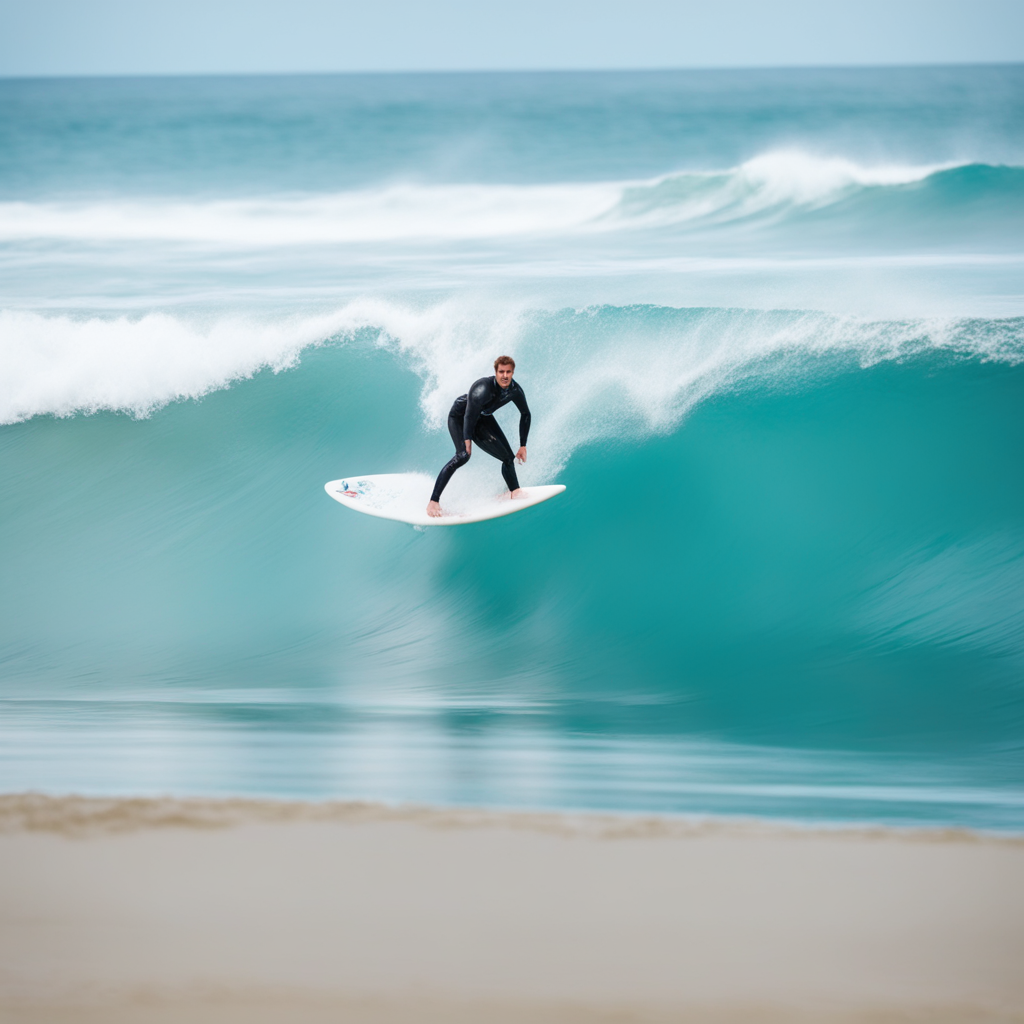

In [16]:
image.show()